### Цели и задачи проекта

Вас пригласили поучаствовать в одном из проектов UNICEF — международного подразделения ООН, чья миссия состоит в повышении уровня благополучия детей по всему миру. 

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

Для этого нужно построить модель, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы. 

##### Цель проекта: Сделать выводы о качестве данных и рекомендовать определенные признаки для построения модели.

##### Задачи проекта: Провести разведывательный анализ данных (определить количество пустых строк, найти и убрать выбросы, построить гистограммы распределений и провести корреляционный анализ количественных переменных, провести анализ номинативных переменных)


### Подгружаем необходимые модули и загружаем датасет.

In [1]:
# подгружаем необходимые модули
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

# подгружаем файл в датасет
math = pd.read_csv('stud_math.csv')

### Место для функций, которые будем использовать ниже.

In [2]:
# функция для просмотра харктеристик датасета
def eda_est(df): 
    eda_df = {}
    eda_df['null_sum'] = df.isnull().sum()
    eda_df['null_pct'] = round(df.isnull().mean()*100, 1)
    eda_df['dtypes'] = df.dtypes
    eda_df['uniq_val'] = df.nunique()
    eda_df['count'] = df.count()
    eda_df['mean'] = df.mean()
    eda_df['median'] = df.median()
    eda_df['min'] = df.min()
    eda_df['max'] = df.max()
    
    return pd.DataFrame(eda_df)

In [3]:
# функция для построения диаграммы распределения
def num_plt(col, bn):
    fig, ax = plt.subplots(1,2,figsize=(20,5))
    sns.distplot(math[col], hist=True, bins=bn, ax=ax[0])
    sns.boxplot(math[col], ax=ax[1])

In [4]:
# фукция для построения распределния и получения данных по iqr
def iqr(q):
    median = q.median()
    IQR = q.quantile(0.75) - q.quantile(0.25)
    perc25 = q.quantile(0.25)
    perc75 = q.quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),"IQR: {}, \
          ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    sns.distplot(q.loc[q.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)])

In [5]:
# функция для построения боксплотов
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', data=math.loc[math.loc[:, column].isin(math.loc[:, column].value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [6]:
# функция для проведения теста Стьюдента
def get_stat_dif(column):
    cols = math.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(math.loc[math.loc[:, column] == comb[0], 'score'].dropna(), 
                     math.loc[math.loc[:, column] == comb[1], 'score'].dropna()).pvalue <= 0.05/len(combinations_all):
            print('Найдены статистически значимые различия для колонки', column)
            break          

### Переходим непосредственно к исследованию данных.

#### Посмотрим в целом на датасет.

In [7]:
math.sample(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
134,GP,M,15,R,GT3,T,3.0,4.0,at_home,teacher,course,mother,NaN,2.0,0.0,no,yes,no,no,yes,-6.0,yes,no,yes,5.0,3.0,3.0,5.0,0.0,0.0
165,GP,M,16,U,GT3,T,3.0,2.0,services,services,course,mother,2.0,1.0,1.0,no,yes,no,yes,no,-3.0,no,no,no,4.0,5.0,2.0,2.0,16.0,60.0
33,GP,M,15,U,LE3,T,3.0,3.0,other,other,NaN,mother,1.0,2.0,0.0,no,NaN,no,yes,no,-6.0,yes,yes,no,5.0,3.0,2.0,2.0,0.0,60.0
120,GP,F,15,U,GT3,T,1.0,2.0,at_home,NaN,course,mother,1.0,2.0,0.0,no,no,no,no,no,-6.0,yes,yes,no,3.0,2.0,3.0,1.0,NaN,75.0
309,GP,F,19,U,LE3,T,1.0,1.0,at_home,NaN,reputation,other,1.0,2.0,1.0,yes,yes,NaN,yes,no,-6.0,yes,yes,no,NaN,4.0,3.0,3.0,18.0,50.0


#### Немного переименуем колонки (сделаем везде строчные буквы + укоротим название одной колонки).

In [8]:
math.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

In [9]:
math.columns = ['school', 'sex', 'age', 'address', 'famsize', 'pstatus', 'medu', 'fedu',
               'mjob', 'fjob', 'reason', 'guardian', 'traveltime', 'studytime',
               'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
               'studytime_gran', 'higher', 'internet', 'romantic', 'famrel',
               'freetime', 'goout', 'health', 'absences', 'score']

#### Посмотрим на характеристики датасета. Для этого применим кастомную функцию eda_est.

In [10]:
eda_est(math).sort_values(by=['dtypes', 'uniq_val'])

,null_sum,null_pct,dtypes,uniq_val,count,mean,median,min,max
age,0,0.0,int64,8,395,16.696203,17.0,15,22
failures,22,5.6,float64,4,373,0.337802,0.0,0,3
studytime,7,1.8,float64,4,388,2.038660,2.0,1,4
studytime_gran,7,1.8,float64,4,388,-6.115979,-6.0,-12,-3
traveltime,28,7.1,float64,4,367,1.438692,1.0,1,4
freetime,11,2.8,float64,5,384,3.231771,3.0,1,5
goout,8,2.0,float64,5,387,3.105943,3.0,1,5
health,15,3.8,float64,5,380,3.531579,4.0,1,5
medu,3,0.8,float64,5,392,2.750000,3.0,0,4
famrel,27,6.8,float64,6,368,3.937500,4.0,-1,5


#### Также визуально оценим распределение пропусков по датасету.

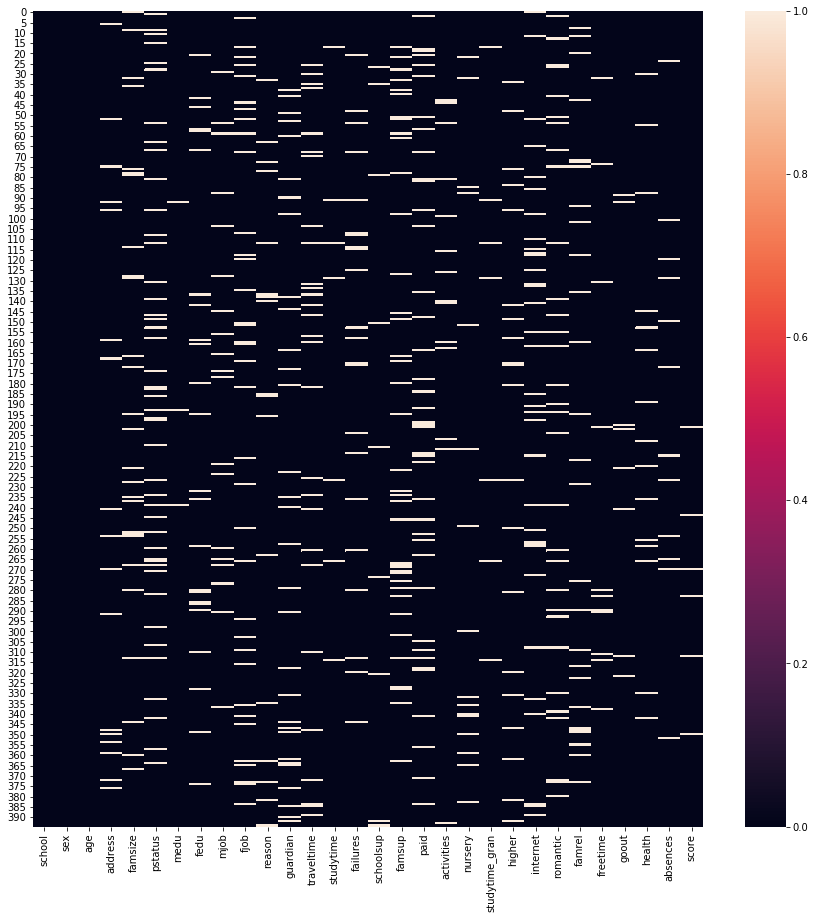

In [11]:
plt.subplots(figsize=(15, 15))
sns.heatmap(math.isnull())

Видим, что:
- Пропуски присутствуют почти во всех столбцах. Доля пропусков в некоторых признаках доходит до 10-11 процентов.
- Пропуски распределены равномерно по датасету, поэтому не имеет смысла удалять строки с пропусками. Мы потеряем подавляющую часть данных.
- Количество уникальных значений в категориальных переменных невелико.
- Исходя из описания и полученных уже данных, делаем вывод, что истинно количественных признаков у нас 3: abcenses, age, score.
- В признаке famrel есть минимальное значение равное -1, чего быть не может.
- В признаке fedu есть максимально значение равное 40, чего быть не может.

Считаю, что это опечатки, поэтому не будем их удалять, а поправим.

Сделаем замену famrel = -1 на 1, проверив перед этим количество таких записей.

In [12]:
display(pd.DataFrame(math.famrel.value_counts()))

,famrel
4.0,182
5.0,99
3.0,62
2.0,17
1.0,7
-1.0,1


In [13]:
math.famrel = math.famrel.apply(lambda x: 1.0 if x == -1.0 else x)

Сделаем замену fedu = 40.0 на 4.0, проверив перед этим количество таких записей.

In [14]:
display(pd.DataFrame(math.fedu.value_counts()))

,fedu
2.0,106
3.0,96
4.0,88
1.0,78
0.0,2
40.0,1


In [15]:
math.fedu = math.fedu.apply(lambda x: 4.0 if x == 40.0 else x)

#### Перейдем к анализу количественных признаков.
Построим распределение количественных переменных и проверим выбросы для начала для целевого признака score.

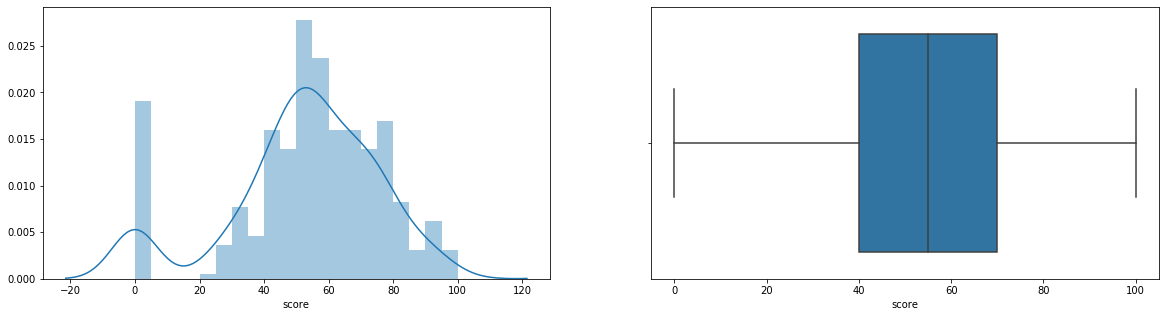

In [16]:
num_plt('score', 20)

Видим, что:
- Распределение целевого признака близко к нормальному.
- Присуствует выброc в районе нуля.

Хотя боксплот и не показывает выброс в районе 0, но, исходя из распределения, я считаю, что score=0 означает, что школьник просто не пришел на экзамен в принципе. Сохранение этого значения не поможет нам в создании модели, так как мы хотим предсказать баллы, только для тех, кто все-таки пришел на экзамен. То же самое и с Nan. Замена их на какое-то значение будет вводить модель в заблуждение, поэтому удалим их (благо их не так много - 6 штук).

Для начала удалим все строки со score=0, а затем проверим отфильтруем признак по формуле межквартильного размаха.

In [17]:
# удаляем строки со score=0 и Nan
math = math[math['score'].notna()]
math.drop(math[math['score'] == 0].index , inplace=True)
math.shape[0]

352

25-й перцентиль: 45.0, 75-й перцентиль: 70.0, IQR: 25.0,            Границы выбросов: [7.5, 107.5].


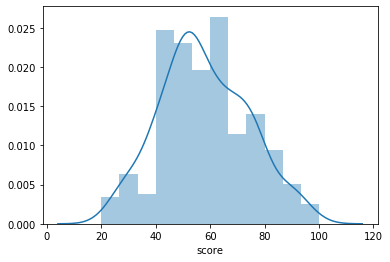

In [18]:
# применим кастомную функцию для межквартильного анализа
iqr(math.score)

In [19]:
# отфильтруем признак по межквартильному размаху
math = math.loc[math.score.between(8, 100)]
math.shape[0]

352

Далее проанализруем признаки absences и age.

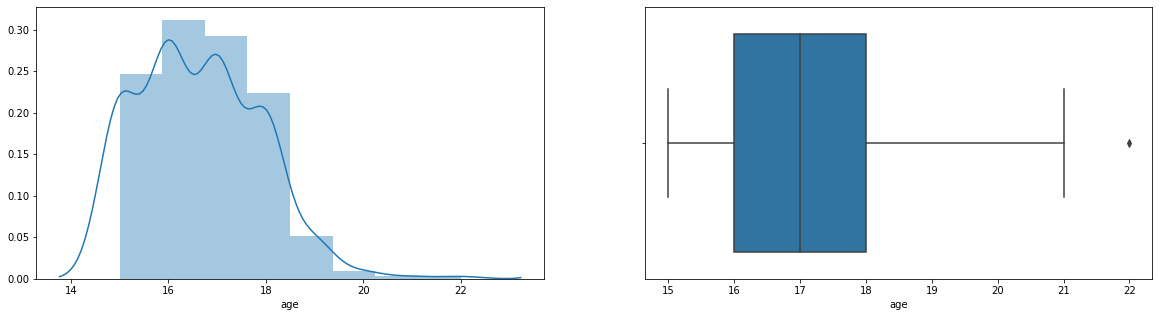

In [20]:
# посмотрим на признак age, но сначала присвоим всем Nan медианное значение
math.age.fillna(math.age.median(), inplace=True)
num_plt('age', 8)

Выбросы видны на обоих графиках. Применяем кастомную функцию для межквартильного анализа и фильтруем датасет.

25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,            Границы выбросов: [13.0, 21.0].


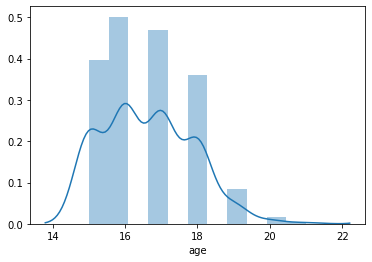

In [21]:
# применим кастомную функцию для межквартильного анализа
iqr(math.age)

In [22]:
# отфильтруем признак по межквартильному размаху от 0 до 17
math = math.loc[math.age.between(15, 21)]
math.shape[0]

351

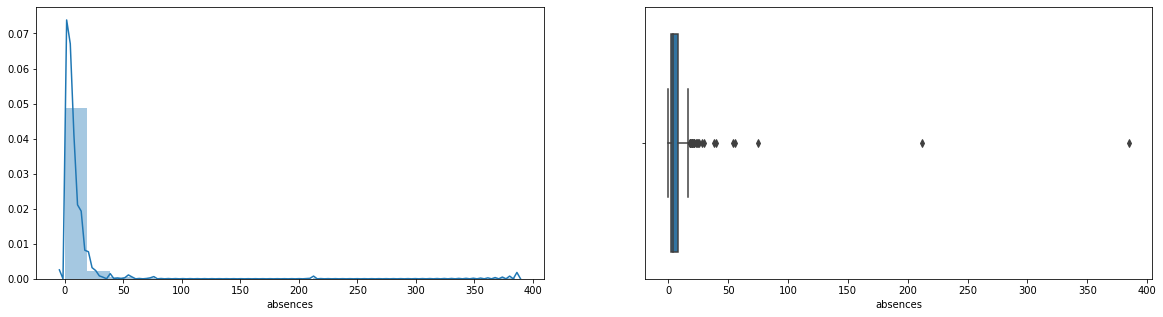

In [23]:
# посмотрим на признак absences, но сначала присвоим всем Nan медианное значение
math.absences.fillna(math.absences.median(), inplace=True)
num_plt('absences', 20)

Выбросы видны на обоих графиках. Применяем кастомную функцию для межквартильного анализа и фильтруем датасет.

25-й перцентиль: 2.0, 75-й перцентиль: 8.0, IQR: 6.0,            Границы выбросов: [-7.0, 17.0].


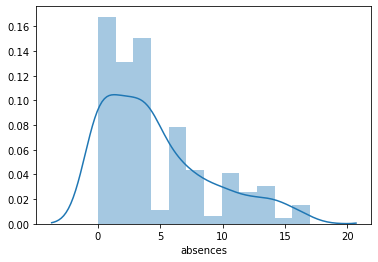

In [24]:
# применим кастомную функцию для межквартильного анализа
iqr(math.absences)

In [25]:
# отфильтруем признак по межквартильному размаху от 0 до 17
math = math.loc[math.absences.between(0, 17)]
math.shape[0]

324

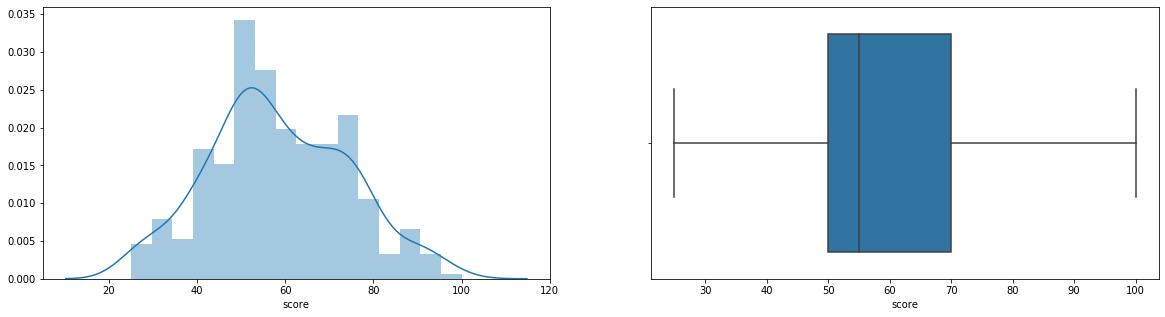

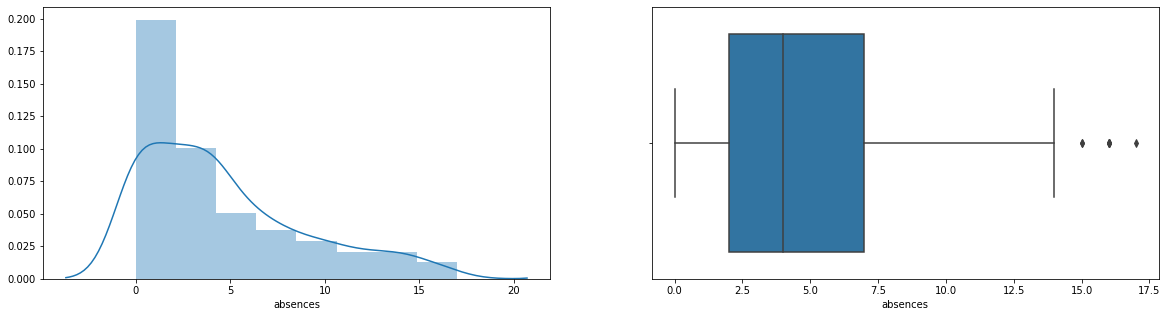

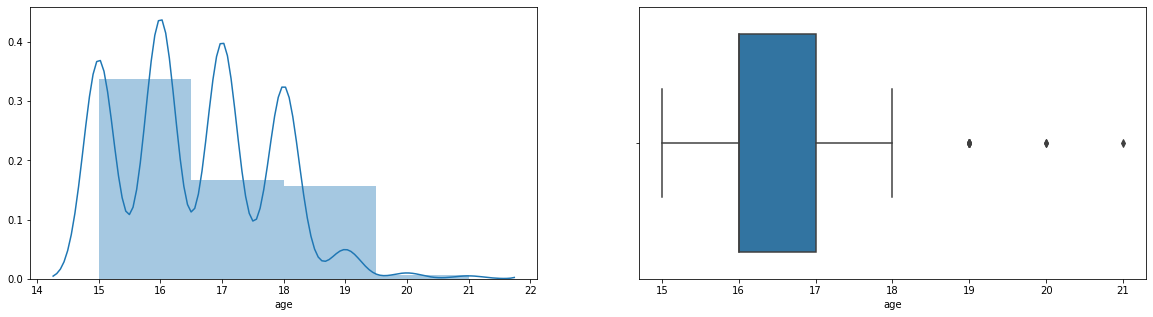

In [26]:
num_plt('score', 16)
num_plt('absences', 8)
num_plt('age', 4)

Мы избавились от выбросов. Три выброса остались остались в признаке abcenses, но пока не будем с ними ничего делать. Распредение по признаку abcenses сдвинуто влево. С этим позже нужно будет что-то сделать.

Теперь проведем корреляционный анализ количественых пееременных. Для этого построим pairplot и матрицу корреляций.

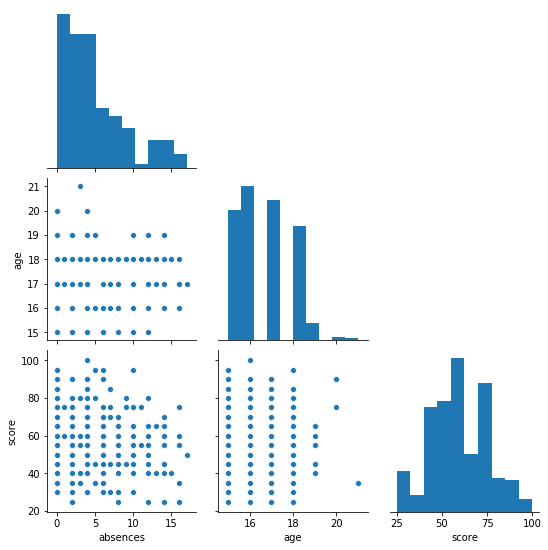

In [27]:
sns.pairplot(math[['absences', 'age', 'score']], corner=True)

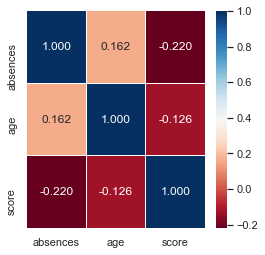

In [28]:
sns.set(font_scale=1)
plt.subplots(figsize=(4, 4))
sns.heatmap(math[['absences', 'age', 'score']].corr(), annot=True, fmt=".3f", linewidths=0.1, cmap="RdBu")

C точки зрения корреляции проблем нет. Возраст и количество пропусков очень слабо коррелируют с целевой переменной, поэтому оставляем их в датасете.

#### Перейдем к анализу категориальных признаков признаков.
Всего у нас 27 категориальных признаков, но в описании их 26. "Лишним" является признак studytime_gran. Поэтому проверим как он соотносится с похожим по названию признаком studytime. Для этого вычислим корреляцию между ними.

In [29]:
math.studytime.corr(math.studytime_gran)

-1.0

Мы имеем обратную 100-процентную корреляцию. Очевидно один из признаков можно удалить. Пусть это будет studytime_gran.

In [30]:
math.drop(columns=['studytime_gran'], inplace=True)

Обратимся теперь к небинарным категориальным признакам. Мы хотим оценить количество уникальных элементов и перекодировать содержимое столбцов с помощью метода pd.factorize в численное представление. При желании потом для некоторых столбцов можно будет применить метод pd.getdummies. Кодирование осуществляем в том числе, чтобы не думать о пропусках. Считаем, что Nan - тоже полезные данные.

In [31]:
# school
display(pd.DataFrame(math.school.value_counts(dropna=False)))

,school
GP,284
MS,40


Пропусков нет. Уникальных значений - 2.

In [32]:
# кодирование
math.school = pd.factorize(math['school'])[0]

In [33]:
# medu и fedu
display(pd.DataFrame(math.medu.value_counts(dropna=False)))
display(pd.DataFrame(math.fedu.value_counts(dropna=False)))

,medu
4.0,116
2.0,81
3.0,78
1.0,44
0.0,3
NaN,2


,fedu
2.0,88
3.0,80
4.0,75
1.0,60
NaN,19
0.0,2


Пропуски присутствуют. Уникальных значений - 5.

In [34]:
math.medu = pd.factorize(math['medu'])[0]
math.fedu = pd.factorize(math['fedu'])[0]

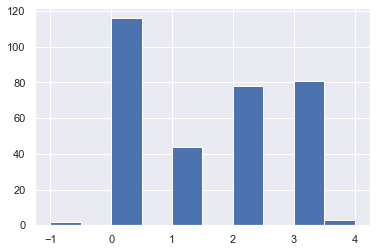

In [35]:
math.medu.hist()

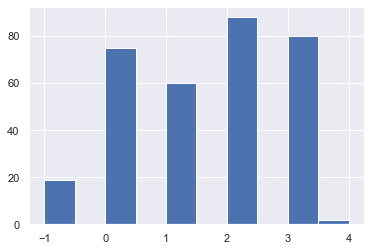

In [36]:
math.fedu.hist()

In [37]:
# mjob и fjob
display(pd.DataFrame(math.mjob.value_counts(dropna=False)))
display(pd.DataFrame(math.fjob.value_counts(dropna=False)))

,mjob
other,104
services,82
teacher,48
at_home,46
health,29
NaN,15


,fjob
other,163
services,80
NaN,29
teacher,24
at_home,14
health,14


Пропуски присутствуют. Уникальных значений - 5.

In [38]:
math.mjob = pd.factorize(math['mjob'])[0]
math.fjob = pd.factorize(math['fjob'])[0]

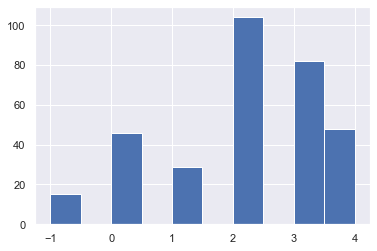

In [39]:
math.mjob.hist()

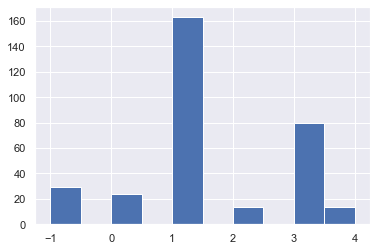

In [40]:
math.fjob.hist()

In [41]:
# reason
display(pd.DataFrame(math.reason.value_counts(dropna=False)))

,reason
course,115
reputation,88
home,76
other,30
NaN,15


Пропуски присутствуют. Уникальных значений - 4.

In [42]:
math.reason = pd.factorize(math['reason'])[0]

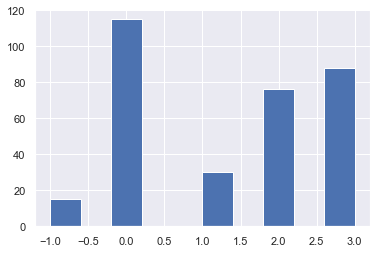

In [43]:
math.reason.hist()

In [44]:
# guardian
display(pd.DataFrame(math.guardian.value_counts(dropna=False)))

,guardian
mother,206
father,76
NaN,28
other,14


Пропуски присутствуют. Уникальных значений - 3.

In [45]:
math.guardian = pd.factorize(math['guardian'])[0]

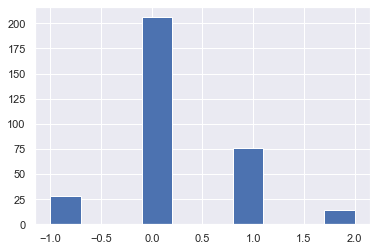

In [46]:
math.guardian.hist()

In [47]:
# traveltime
display(pd.DataFrame(math.traveltime.value_counts(dropna=False)))

,traveltime
1.0,202
2.0,78
NaN,22
3.0,15
4.0,7


Пропуски присутствуют. Уникальных значений - 4.

In [48]:
math.traveltime = pd.factorize(math['traveltime'])[0]

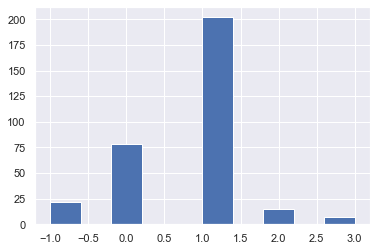

In [49]:
math.traveltime.hist()

In [50]:
# studytime
display(pd.DataFrame(math.studytime.value_counts(dropna=False)))

,studytime
2.0,156
1.0,81
3.0,56
4.0,24
NaN,7


Пропуски присутствуют. Уникальных значений - 4.

In [51]:
math.studytime = pd.factorize(math['studytime'])[0]

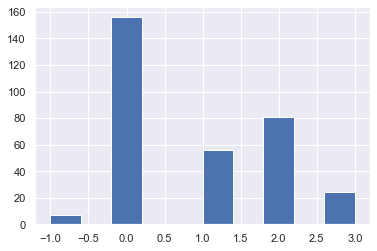

In [52]:
math.studytime.hist()

In [53]:
# failures
display(pd.DataFrame(math.failures.value_counts(dropna=False)))

,failures
0.0,260
1.0,29
NaN,17
2.0,9
3.0,9


Пропуски присутствуют. Уникальных значений - 4.

In [54]:
math.failures = pd.factorize(math['failures'])[0]

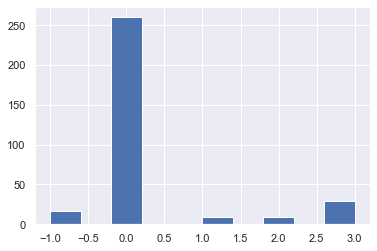

In [55]:
math.failures.hist()

In [56]:
# famrel
display(pd.DataFrame(math.famrel.value_counts(dropna=False)))

,famrel
4.0,151
5.0,83
3.0,49
NaN,21
2.0,13
1.0,7


Пропуски присутствуют. Уникальных значений - 5.

In [57]:
math.famrel = pd.factorize(math['famrel'])[0]

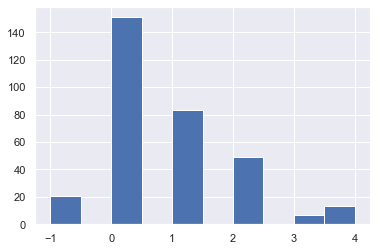

In [58]:
math.famrel.hist()

In [59]:
# freetime
display(pd.DataFrame(math.freetime.value_counts(dropna=False)))

,freetime
3.0,126
4.0,94
2.0,54
5.0,33
1.0,12
NaN,5


Пропуски присутствуют. Уникальных значений - 5.

In [60]:
math.freetime = pd.factorize(math['freetime'])[0]

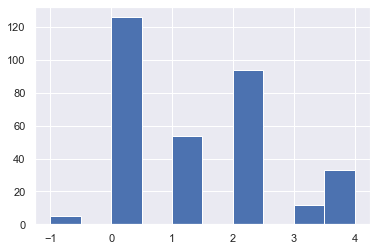

In [61]:
math.freetime.hist()

In [62]:
# goout
display(pd.DataFrame(math.goout.value_counts(dropna=False)))

,goout
3.0,113
2.0,85
4.0,65
5.0,40
1.0,16
NaN,5


Пропуски присутствуют. Уникальных значений - 5.

In [63]:
math.goout = pd.factorize(math['goout'])[0]

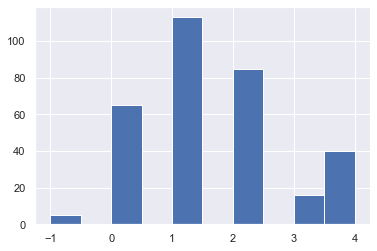

In [64]:
math.goout.hist()

In [65]:
# health
display(pd.DataFrame(math.health.value_counts(dropna=False)))

,health
5.0,114
3.0,73
4.0,51
1.0,41
2.0,32
NaN,13


Пропуски присутствуют. Уникальных значений - 5.

In [66]:
math.health = pd.factorize(math['health'])[0]

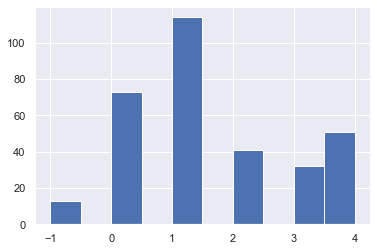

In [67]:
math.health.hist()

Перейдем к бинарным категориальным признакам. Мы хотим перекодировать содержимое столбцов с помощью метода pd.factorize в численное представление. При желании потом можно будет применить метод pd.getdummies. Кодирование осуществляем в том числе, чтобы не думать о пропусках. Считаем, что Nan - тоже полезные данные.

In [68]:
math.sex = pd.factorize(math['sex'])[0]
math.address = pd.factorize(math['address'])[0]
math.famsize = pd.factorize(math['famsize'])[0]
math.pstatus = pd.factorize(math['pstatus'])[0]
math.schoolsup = pd.factorize(math['schoolsup'])[0]
math.famsup = pd.factorize(math['famsup'])[0]
math.paid = pd.factorize(math['paid'])[0]
math.activities = pd.factorize(math['activities'])[0]
math.nursery = pd.factorize(math['nursery'])[0]
math.higher = pd.factorize(math['higher'])[0]
math.internet = pd.factorize(math['internet'])[0]
math.romantic = pd.factorize(math['romantic'])[0]

Все пропуски зачищены.

Построим боксплоты для всех категориальных признаков.

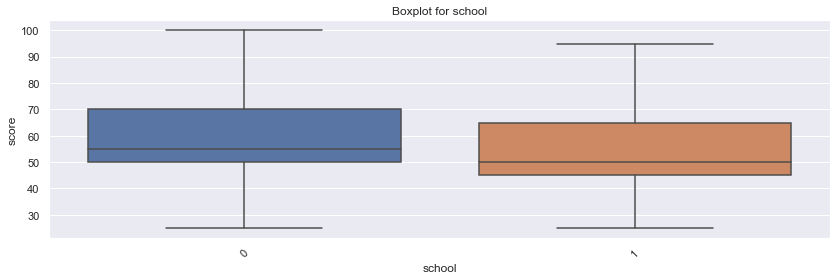

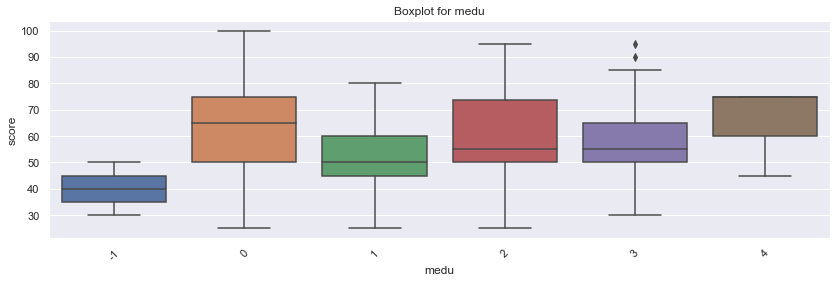

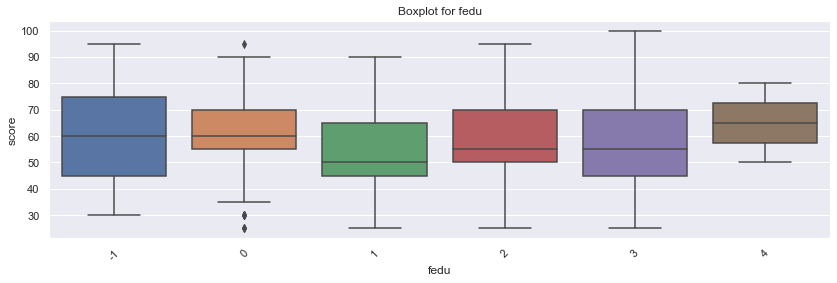

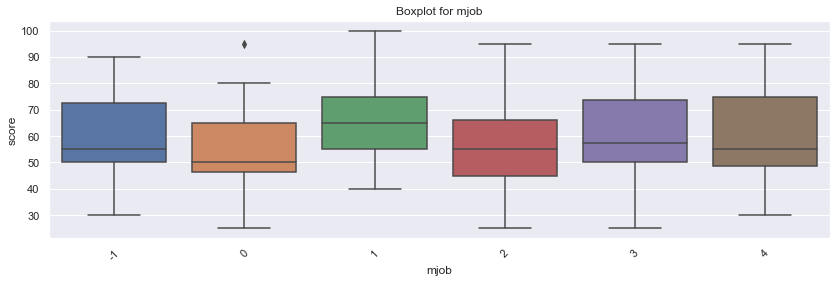

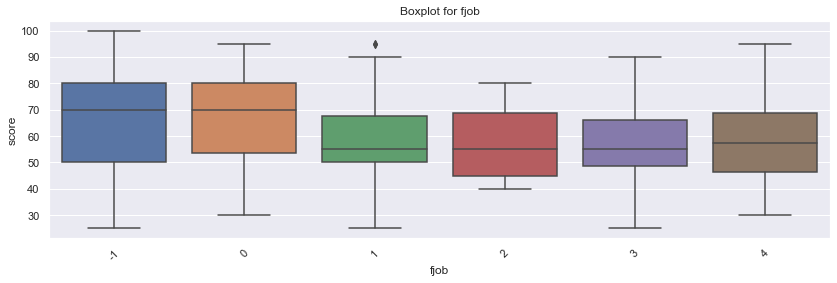

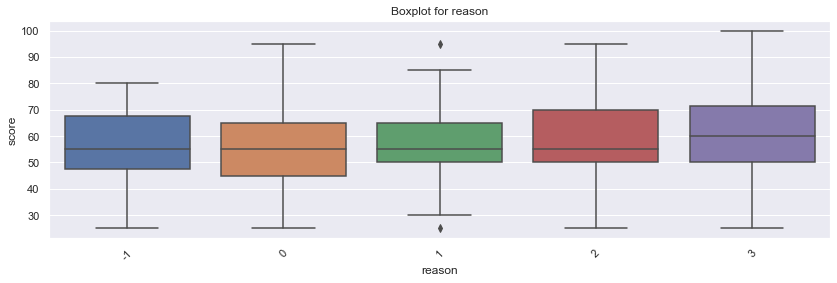

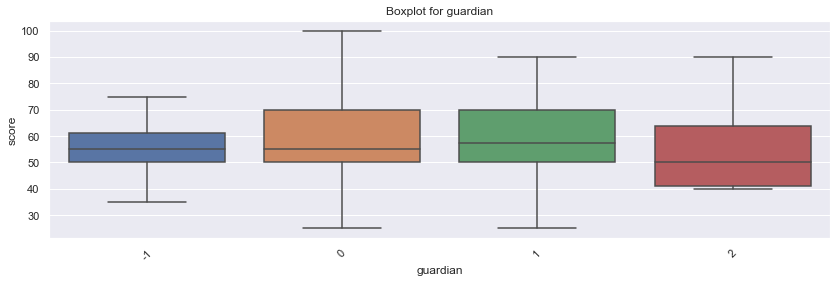

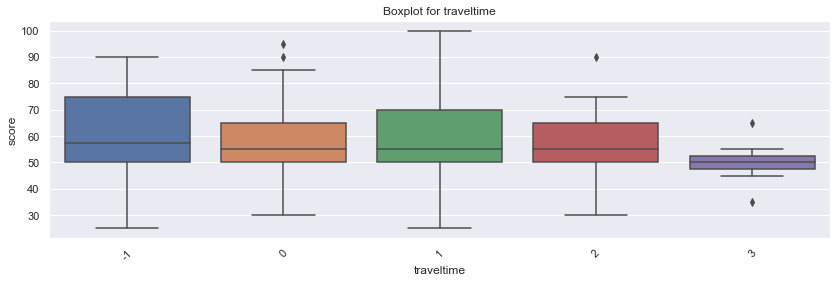

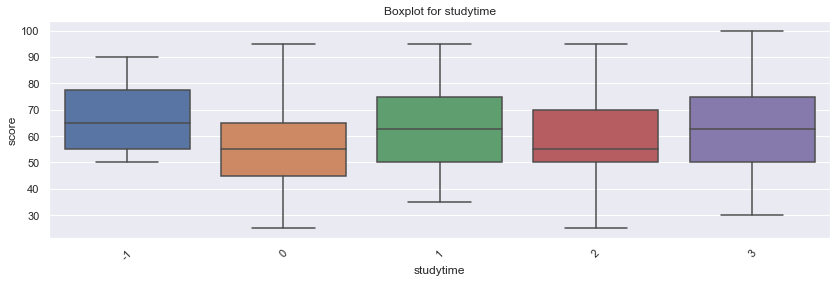

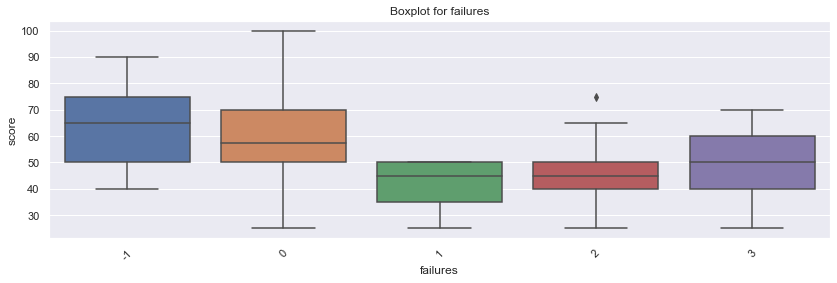

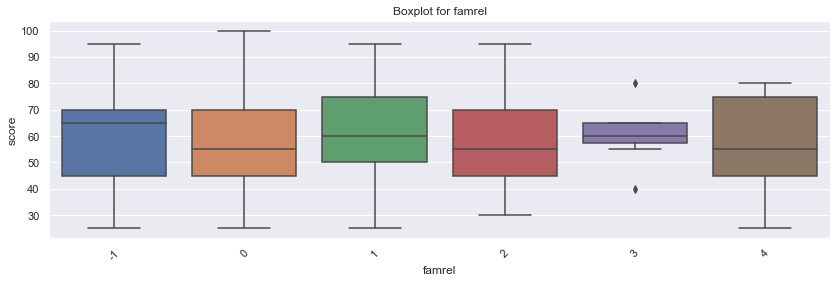

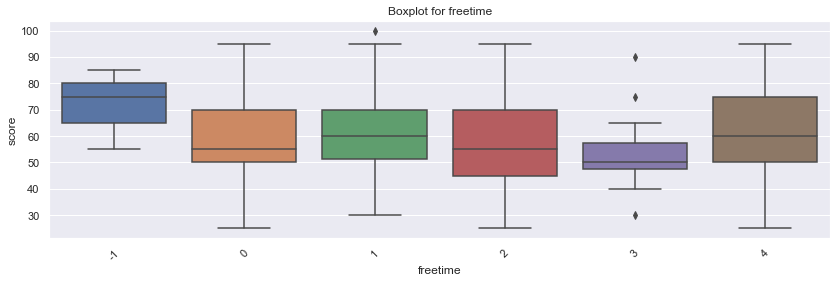

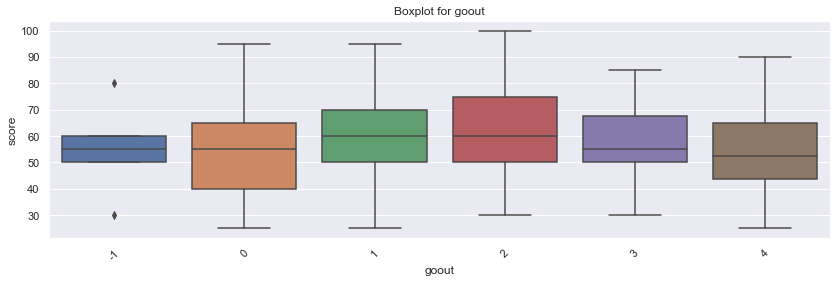

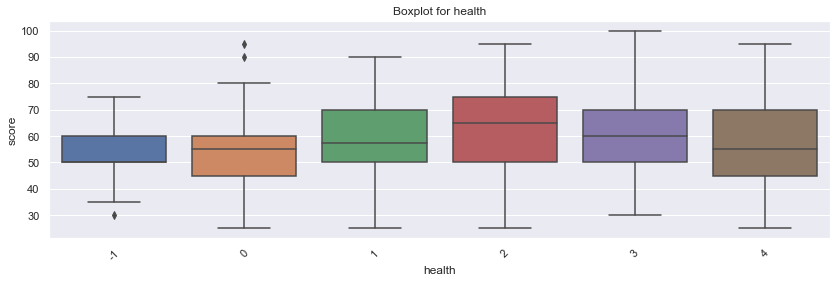

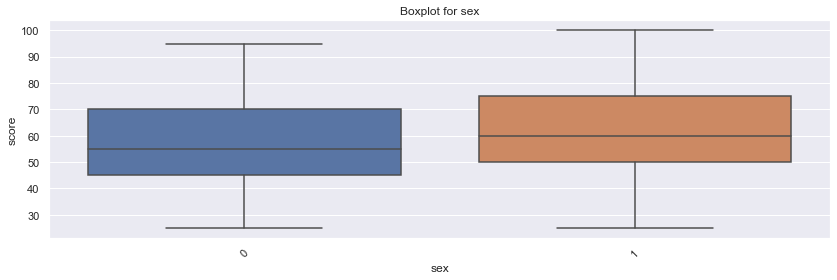

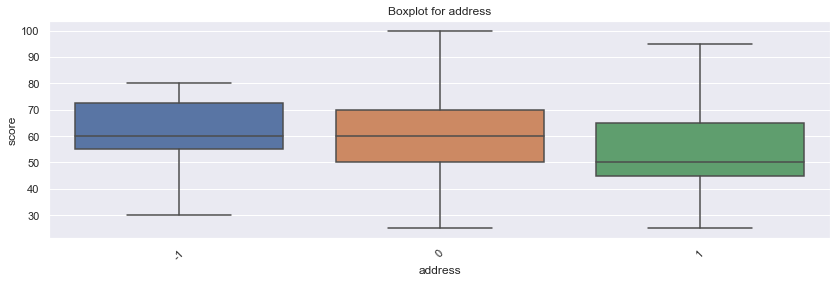

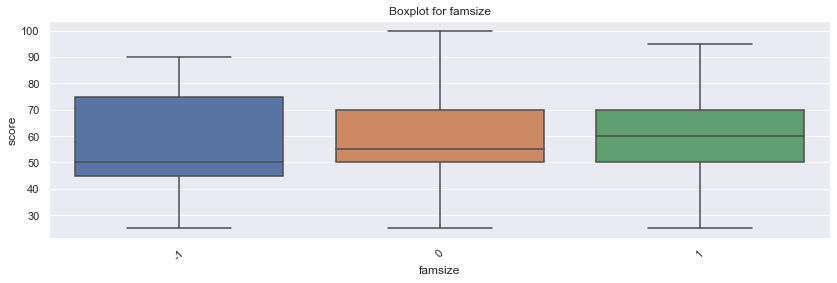

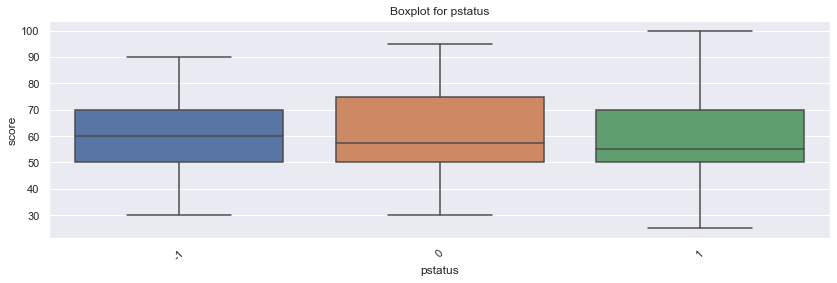

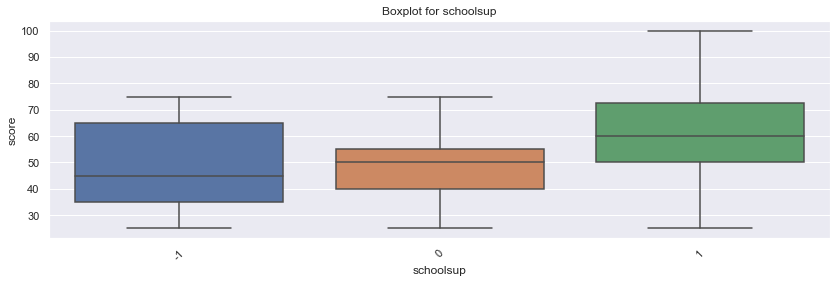

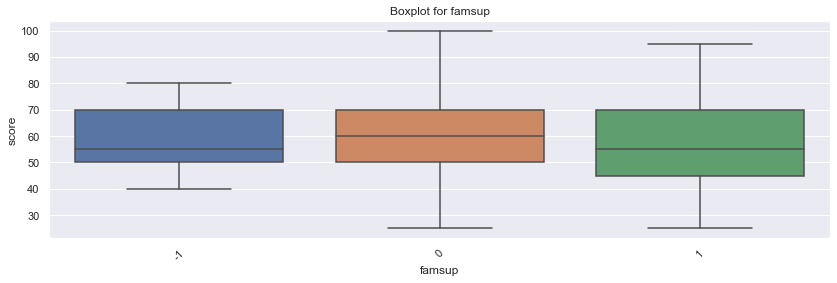

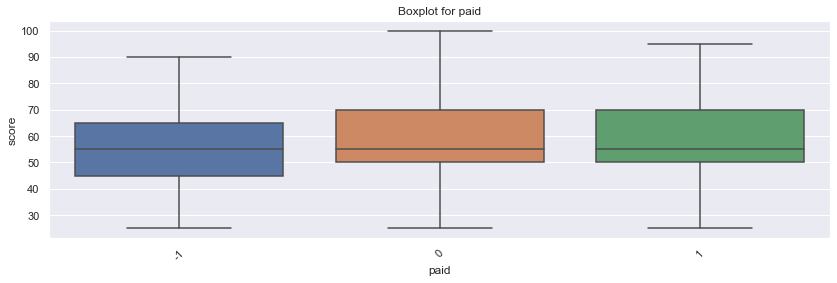

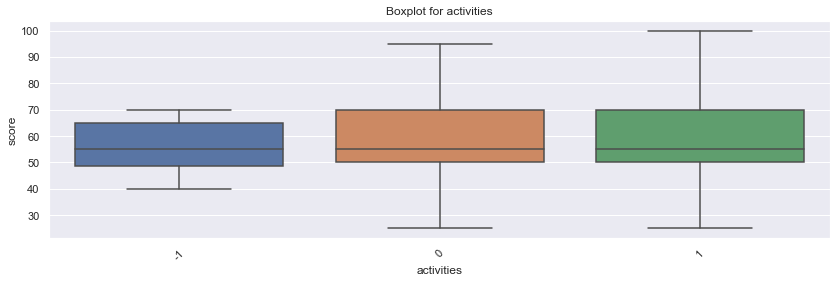

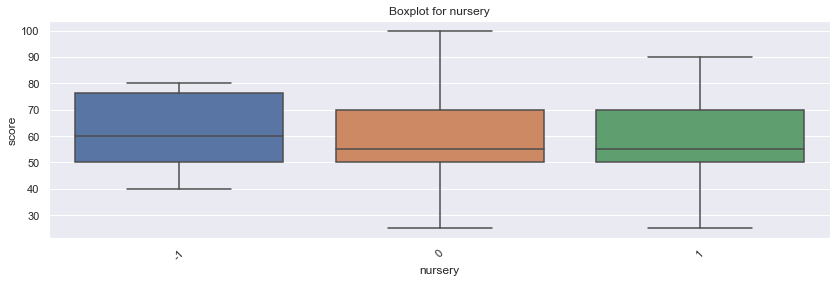

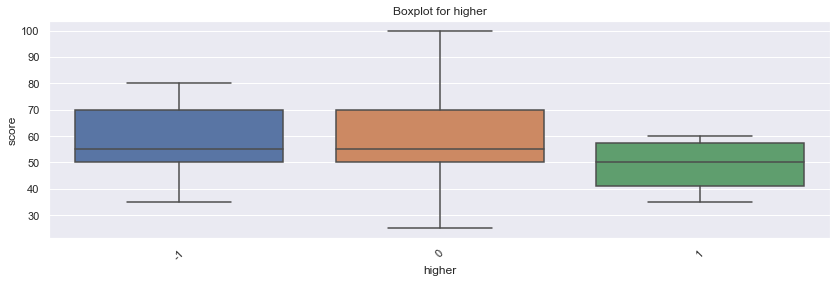

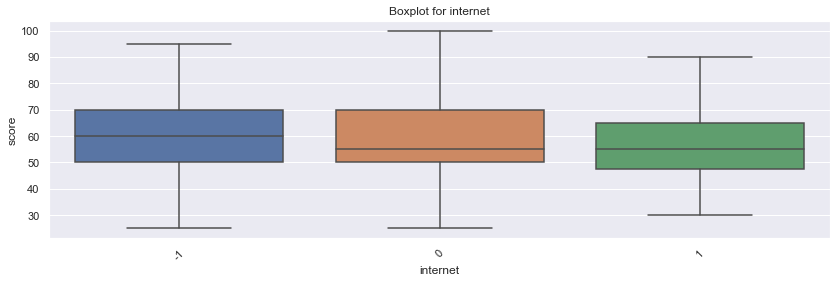

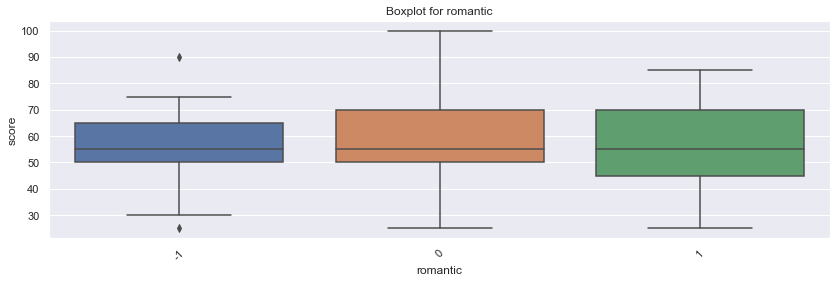

In [69]:
for col in ['school', 'medu', 'fedu', 'mjob', 'fjob', 'reason', 'guardian',
            'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 
            'goout', 'health', 'sex', 'address', 'famsize', 'pstatus',
            'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
            'internet','romantic'
           ]:get_boxplot(col)

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента.

In [70]:
for col in ['school', 'medu', 'fedu', 'mjob', 'fjob', 'reason', 'guardian',
            'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 
            'goout', 'health', 'sex', 'address', 'famsize', 'pstatus',
            'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
            'internet','romantic'
           ]:get_stat_dif(col)

Найдены статистически значимые различия для колонки medu
Найдены статистически значимые различия для колонки fedu
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки goout
Найдены статистически значимые различия для колонки health
Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки schoolsup


Эти категориальные признаки мы и порекомендуем для дальнейшего использования.

### Выводы по датасету

- В наших данных достаточно много пустых значений, только 3 столбца из 30 заполнены полностью. В некоторых процент пропусков доходит до 10-11%.


- Выбросы найдены:
  - в столбце age (убраны по IQR методике)
  - в столбце abcenses (убраны по IQR методике)
  - в столбце score (значение 0.0 удалено, также признак зачищен по IQR методике)


- Можно предположить, что:
  - отрицательная корреляция параметра age и score может говорить о том, что чем выше возраст тем ниже score


- В итоге предлагается использовать следующие притерии: age, absences, medu, fedu, studytime, failures, goout, health, sex, address,schoolsup.